In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
from sklearn.cluster import KMeans
import joblib

In [4]:
# Load sheets from Excel file
file_path = "Customer_Churn_Segmentation_AayushTiwari.xlsx"

In [6]:
df_raw = pd.read_excel(file_path, sheet_name="Raw_Data")
df_feat = pd.read_excel(file_path, sheet_name="Feature Engineering")
df_churn = pd.read_excel(file_path, sheet_name="Churn_Analysis")
df_seg = pd.read_excel(file_path, sheet_name="Segmentation")

In [13]:
df = df_raw.copy()
df["Churned_01"] = df["Churned"].map({"Yes": 1, "No": 0})
df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})

In [14]:
# Optional: One-hot encode Country
df = pd.get_dummies(df, columns=["Country"], drop_first=True)

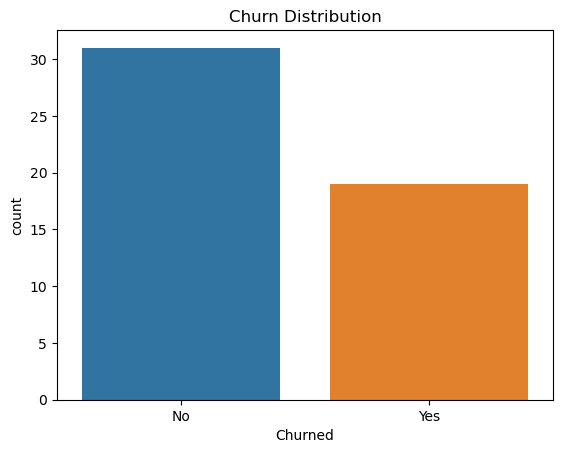

In [15]:
sns.countplot(x="Churned", data=df)
plt.title("Churn Distribution")
plt.show()

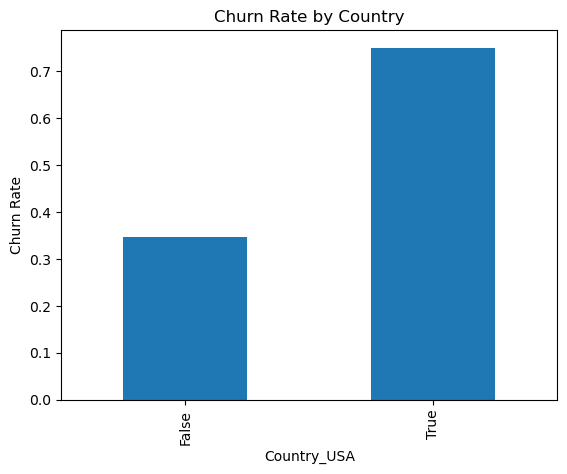

In [16]:
churn_country = df.groupby("Country_USA")["Churned_01"].mean()
churn_country.plot(kind="bar")
plt.title("Churn Rate by Country")
plt.ylabel("Churn Rate")
plt.show()

In [20]:
sns.scatterplot(x="Monthly_Spend (USD)", y="Risk", hue="Churned_01", data=df)
plt.title("Risk vs Spend by Churn")
plt.show()

ValueError: Could not interpret value `Risk` for parameter `y`

In [21]:
print(df.columns.tolist())

['Customer_ID', 'Customer_Name', 'Gender', 'Age', 'Tenure', 'Monthly_Spend (USD)', 'No_of_Products', 'Last_Transaction_Date', 'Churned', 'Churned_01', 'Country_Canada', 'Country_China', 'Country_France', 'Country_Germany', 'Country_India', 'Country_Japan', 'Country_Spain', 'Country_UAE', 'Country_USA']


In [22]:
# Normalize components
from sklearn.preprocessing import MinMaxScaler

In [23]:
scaler = MinMaxScaler()

In [25]:
df["Tenure_Score"] = 1 - scaler.fit_transform(df[["Tenure"]])  # Less tenure = more risk
df["Low_Spend_Score"] = 1 - scaler.fit_transform(df[["Monthly_Spend (USD)"]])
df["Products_Score"] = 1 - scaler.fit_transform(df[["No_of_Products"]])

In [26]:
# Combine them into a Risk Score
df["Risk_Score"] = (
    0.4 * df["Tenure_Score"] +
    0.4 * df["Low_Spend_Score"] +
    0.2 * df["Products_Score"]
).round(2)

In [28]:
print(df[["Tenure", "Monthly_Spend (USD)", "No_of_Products", "Risk_Score"]].head())

   Tenure  Monthly_Spend (USD)  No_of_Products  Risk_Score
0       4               378.57               1        0.85
1       1               617.88               2        0.88
2       4               829.61               5        0.54
3       1               955.28               2        0.79
4       4              1174.33               3        0.55


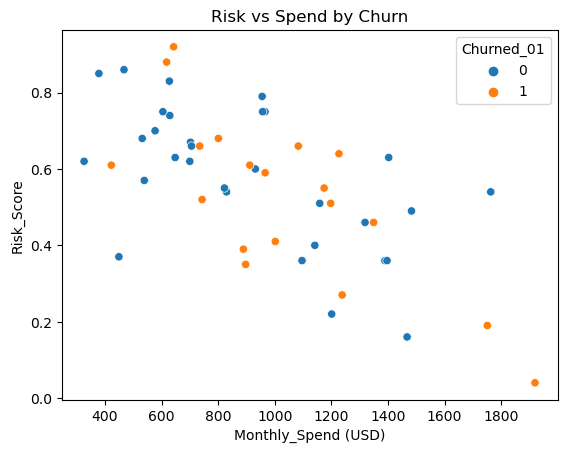

In [30]:
sns.scatterplot(x="Monthly_Spend (USD)", y="Risk_Score", hue="Churned_01", data=df)
plt.title("Risk vs Spend by Churn")
plt.show()

In [32]:
features = ['Age', 'Tenure', 'Monthly_Spend (USD)', 'Risk_Score', 'No_of_Products', 'Gender'] + \
           [col for col in df.columns if col.startswith("Country_")]
X = df[features]
y = df["Churned_01"]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [35]:
X_train_clean = X_train.dropna()
y_train_clean = y_train.loc[X_train_clean.index]

In [36]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_clean, y_train_clean)

RandomForestClassifier(random_state=42)

In [37]:
from sklearn.impute import SimpleImputer

In [38]:
imputer = SimpleImputer(strategy="mean")  # or "median", "most_frequent", etc.
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [39]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_imputed, y_train)

RandomForestClassifier(random_state=42)

In [40]:
from sklearn.pipeline import Pipeline

In [41]:
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42))
])

In [42]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()),
                ('rf', RandomForestClassifier(random_state=42))])

In [43]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [44]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [45]:
# 1. Create the imputer
imputer = SimpleImputer(strategy='mean')

In [46]:
# 2. Fit on training data and transform both train and test
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [47]:
# 3. Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_imputed, y_train)

RandomForestClassifier(random_state=42)

In [48]:
# 4. Predict
y_pred = model.predict(X_test_imputed)

In [49]:
# 5. Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.50      0.67         4

    accuracy                           0.80        10
   macro avg       0.88      0.75      0.76        10
weighted avg       0.85      0.80      0.78        10



In [53]:
segment_features = df_seg[["Spend", "Tenure", "Risk Score", "No_Products"]]
scaled = StandardScaler().fit_transform(segment_features)

In [52]:
print(df_seg.columns.tolist())

['Customer_ID', 'Country', 'Age', 'Spend', 'Tenure', 'Churned', 'Risk Score', 'No_Products', 'Segment', 'Segment_ID']


In [54]:
kmeans = KMeans(n_clusters=4, random_state=42)
df_seg["Segment_Label"] = kmeans.fit_predict(scaled)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


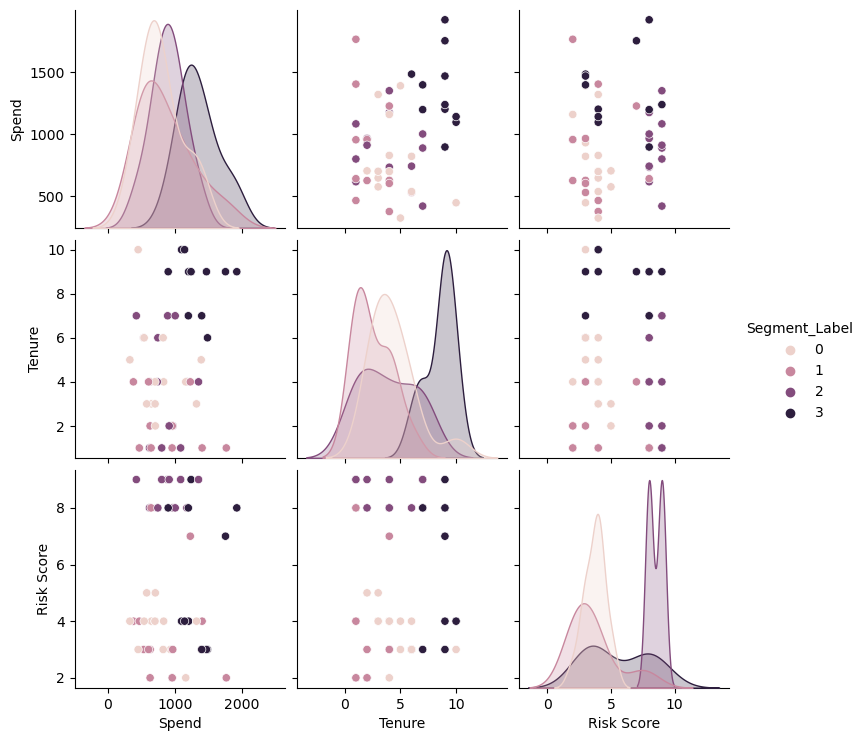

In [56]:
sns.pairplot(df_seg, hue="Segment_Label", vars=["Spend", "Tenure", "Risk Score"])
plt.show()

In [57]:
# Save Model
joblib.dump(kmeans, "kmeans_segmentation_model.joblib")

['kmeans_segmentation_model.joblib']

In [58]:
df_seg.to_csv("segmented_customers_output.csv", index=False)